In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_path = '../../data/postprocessed/SMMemory/'

mapping_table = {
    'NN50Perclenet5': 'LeNet5',
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (file.endswith('_telemetry.csv') and ('NN50Perc' in file or '5min' in file))]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Index'] = range(len(df))
    df['progress'] = df['Index'].transform(
        lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df['Range'] = int(csv_name.split('_')[1].split('_')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    print(csv_name.split('_')[0])

    telemetry=pd.concat([telemetry, df], ignore_index=True)

PC_profiling = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    # print(df[df.isna()])
    PC_profiling=pd.concat([PC_profiling, df], ignore_index=True)

../../data/postprocessed/SMMemory/NN50Perclenet5_1_telemetry.csv
NN50Perclenet5
../../data/postprocessed/SMMemory/NN50Percmobilenetv2_1_telemetry.csv
NN50Percmobilenetv2
../../data/postprocessed/SMMemory/NN50Percresnet18_1_telemetry.csv
NN50Percresnet18
../../data/postprocessed/SMMemory/gpuburn5min_1_telemetry.csv
gpuburn5min
../../data/postprocessed/SMMemory/NN50Percmnasnet05_1_telemetry.csv
NN50Percmnasnet05
../../data/postprocessed/SMMemory/NN50PercLeNet5_1.csv
../../data/postprocessed/SMMemory/gpuburn5min_1.csv
../../data/postprocessed/SMMemory/NN50Percresnet18_1.csv
../../data/postprocessed/SMMemory/NN50Percmnasnet05_1.csv
../../data/postprocessed/SMMemory/NN50Percmobilenetv2_1.csv


In [3]:
# Imposta come indice
PC_profiling['timestamp']=pd.to_datetime(PC_profiling['duration_ms'], yearfirst=True)
PC_profiling.set_index('timestamp', inplace=True)
PC_profiling\
    .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\
        ['metric_value']\
            .mean()\
                .reset_index()

PC_agg_df = PC_profiling.sort_values(by=[
    'timestamp'
])

PC_agg_df['relative_second'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
]).cumcount()

PC_agg_df['progress'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
])['relative_second'].transform(
    lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

/tmp/ipykernel_57353/4100994835.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\


## Select only a portion of the DataFrame

In [4]:
PC_df_portion = PC_agg_df[
        (PC_agg_df['progress'] >= 60) &
        (PC_agg_df['progress'] <= 80)
    ]
telemetry_df_portion = telemetry[
        (telemetry['progress'] >= 60) &
        (telemetry['progress'] <= 80)
    ]

In [5]:
location_mapping={
    'sm': 'Streaming Multiprocessor',
    'idc': 'InDexed Constant Cache'
}

PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)

metric_event_mapping= {
    'warps_active': 'Achieved occupancy in terms of active warps',
    't_set_accesses_pipe_lsu_mem_global_op_atom': 'Atomic operations accessing global memory',
    't_set_accesses_pipe_lsu_mem_global_op_red': 'Reduction operations accessing global memory',
    'sass_average_branch_targets_threads_uniform': 'Average Branch Target Uniformity per Warp',
    'inst_executed_pipe_cbu': 'Control & Branch Instructions Executed per SM Sub-Partition',
    'inst_executed_pipe_adu': 'Address Calculation Instructions Executed per SM Sub-Partition',
    'inst_executed_pipe_fp64': 'Double-Precision Floating Point Instructions Executed per SM Sub-Partition',
    'bytes_read': 'Total Global Memory Bytes Read (DRAM)',
    'throughput': 'DRAM utilization',
    'bytes_write': 'Total Global Memory Bytes Read (DRAM)',
    'warps_eligible': 'Eligible Warps per SM Sub-Partition (Ready for Execution)',
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    'sass_thread_inst_executed_op_fp64_pred_on': 'FP64 Instructions Executed per Thread with Predication ON (SM)', ## 
    'sass_thread_inst_executed_op_integer_pred_on': 'Integer Instructions Executed per Thread with Predication ON (SM)',
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',
    'thread_inst_executed_per_inst_executed': 'Thread Instructions Executed per Instructions Executed'
}

PC_df_portion['HR_metric_name'] = PC_df_portion['metric_name'].map(metric_event_mapping)

df_sm = PC_df_portion[PC_df_portion['HR_location']=='Streaming Multiprocessor']
df_smsp = PC_df_portion[PC_df_portion['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1 = PC_df_portion[PC_df_portion['HR_location']=='L1 Cache']
df_dram = PC_df_portion[PC_df_portion['HR_location']=='Dynamic RAM']

dfs = {
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor SubPartition': df_smsp,
    'L1 Cache': df_l1,
    'Dynamic RAM':df_dram
    }

df_pivot_smsp = df_smsp.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_l1 = df_l1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram = df_dram.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp,
    'L1 Cache': df_pivot_l1,
    'Dynamic RAM':df_pivot_dram
    }

metric_full_name = PC_df_portion['HR_location'] +' '+ PC_df_portion['HR_metric_name']


/tmp/ipykernel_57353/1161822235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)
/tmp/ipykernel_57353/1161822235.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PC_df_portion['HR_metric_name'] = PC_df_portion['metric_name'].map(metric_event_mapping)


/tmp/ipykernel_57353/3711208839.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57353/3711208839.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57353/3711208839.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57353/3711208839.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_57353/3711208839.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci

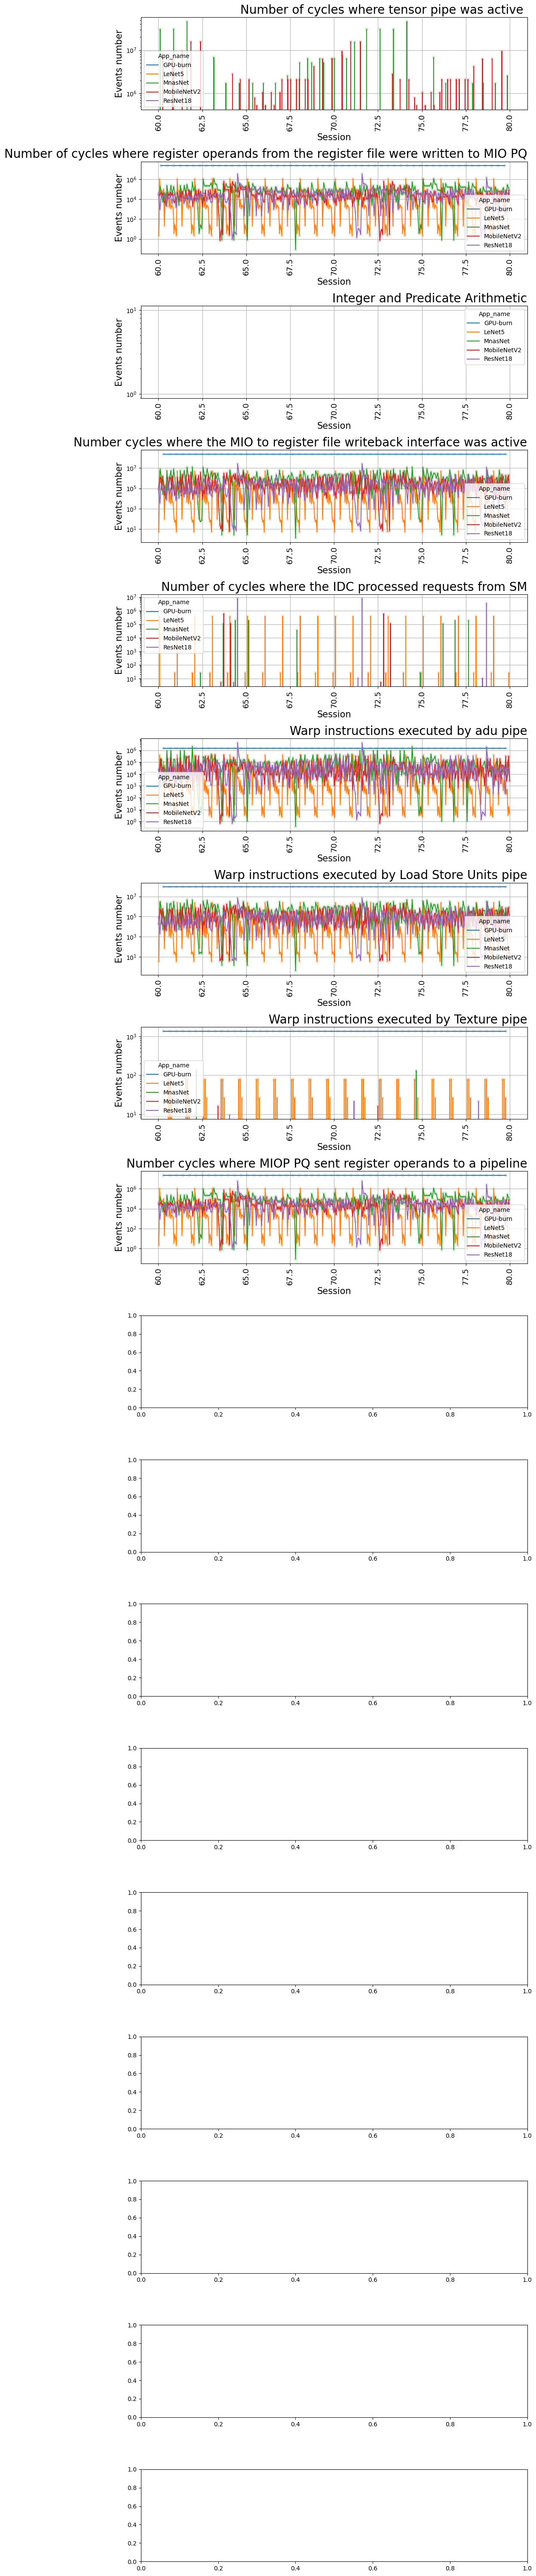

In [6]:
fig, ax = plt.subplots(18,1,figsize=(10,60))
for metric_idx in range(len(PC_df_portion['HR_metric_name'].unique())):
    metric_name = PC_df_portion['HR_metric_name'].unique()[metric_idx]
    data = PC_df_portion[PC_df_portion['HR_metric_name'] == metric_name]
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

In [12]:
merged_dfs = {}
for key, PC_df in pivot_dfs.items():
    print(PC_df.columns)
    common_cols = set(PC_df.columns).intersection(telemetry_df_portion.columns) - {'progress'}

    telemetry_df_portion_reduced = telemetry_df_portion.drop(columns=common_cols)

    merged_df = pd.merge_asof(
        telemetry_df_portion_reduced.sort_values('progress'),
        PC_df.sort_values('progress'),
        on=['progress'],
        direction='nearest',
        tolerance=1.5
    )

    if key == 'Streaming Multiprocessor':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Integer and Predicate Arithmetic',
       'Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of cycles where tensor pipe was active ',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe']]
    else:
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Number of cycles where the IDC processed requests from SM']]
        
    merged_dfs[key]=merged_df

Index(['session_id', 'HR_location', 'range_name', 'Range', 'App_name',
       'progress', 'Integer and Predicate Arithmetic',
       'Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of cycles where tensor pipe was active ',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe'],
      dtype='object', name='HR_metric_name')
Index(['session_id', 'HR_location', 'range_name', 'Range', 'App_name',
       'progress',
       'Number of cycles where the IDC processed requests from SM'],
      dtype='object', name='HR_metric_name')


Streaming Multiprocessor
InDexed Constant Cache


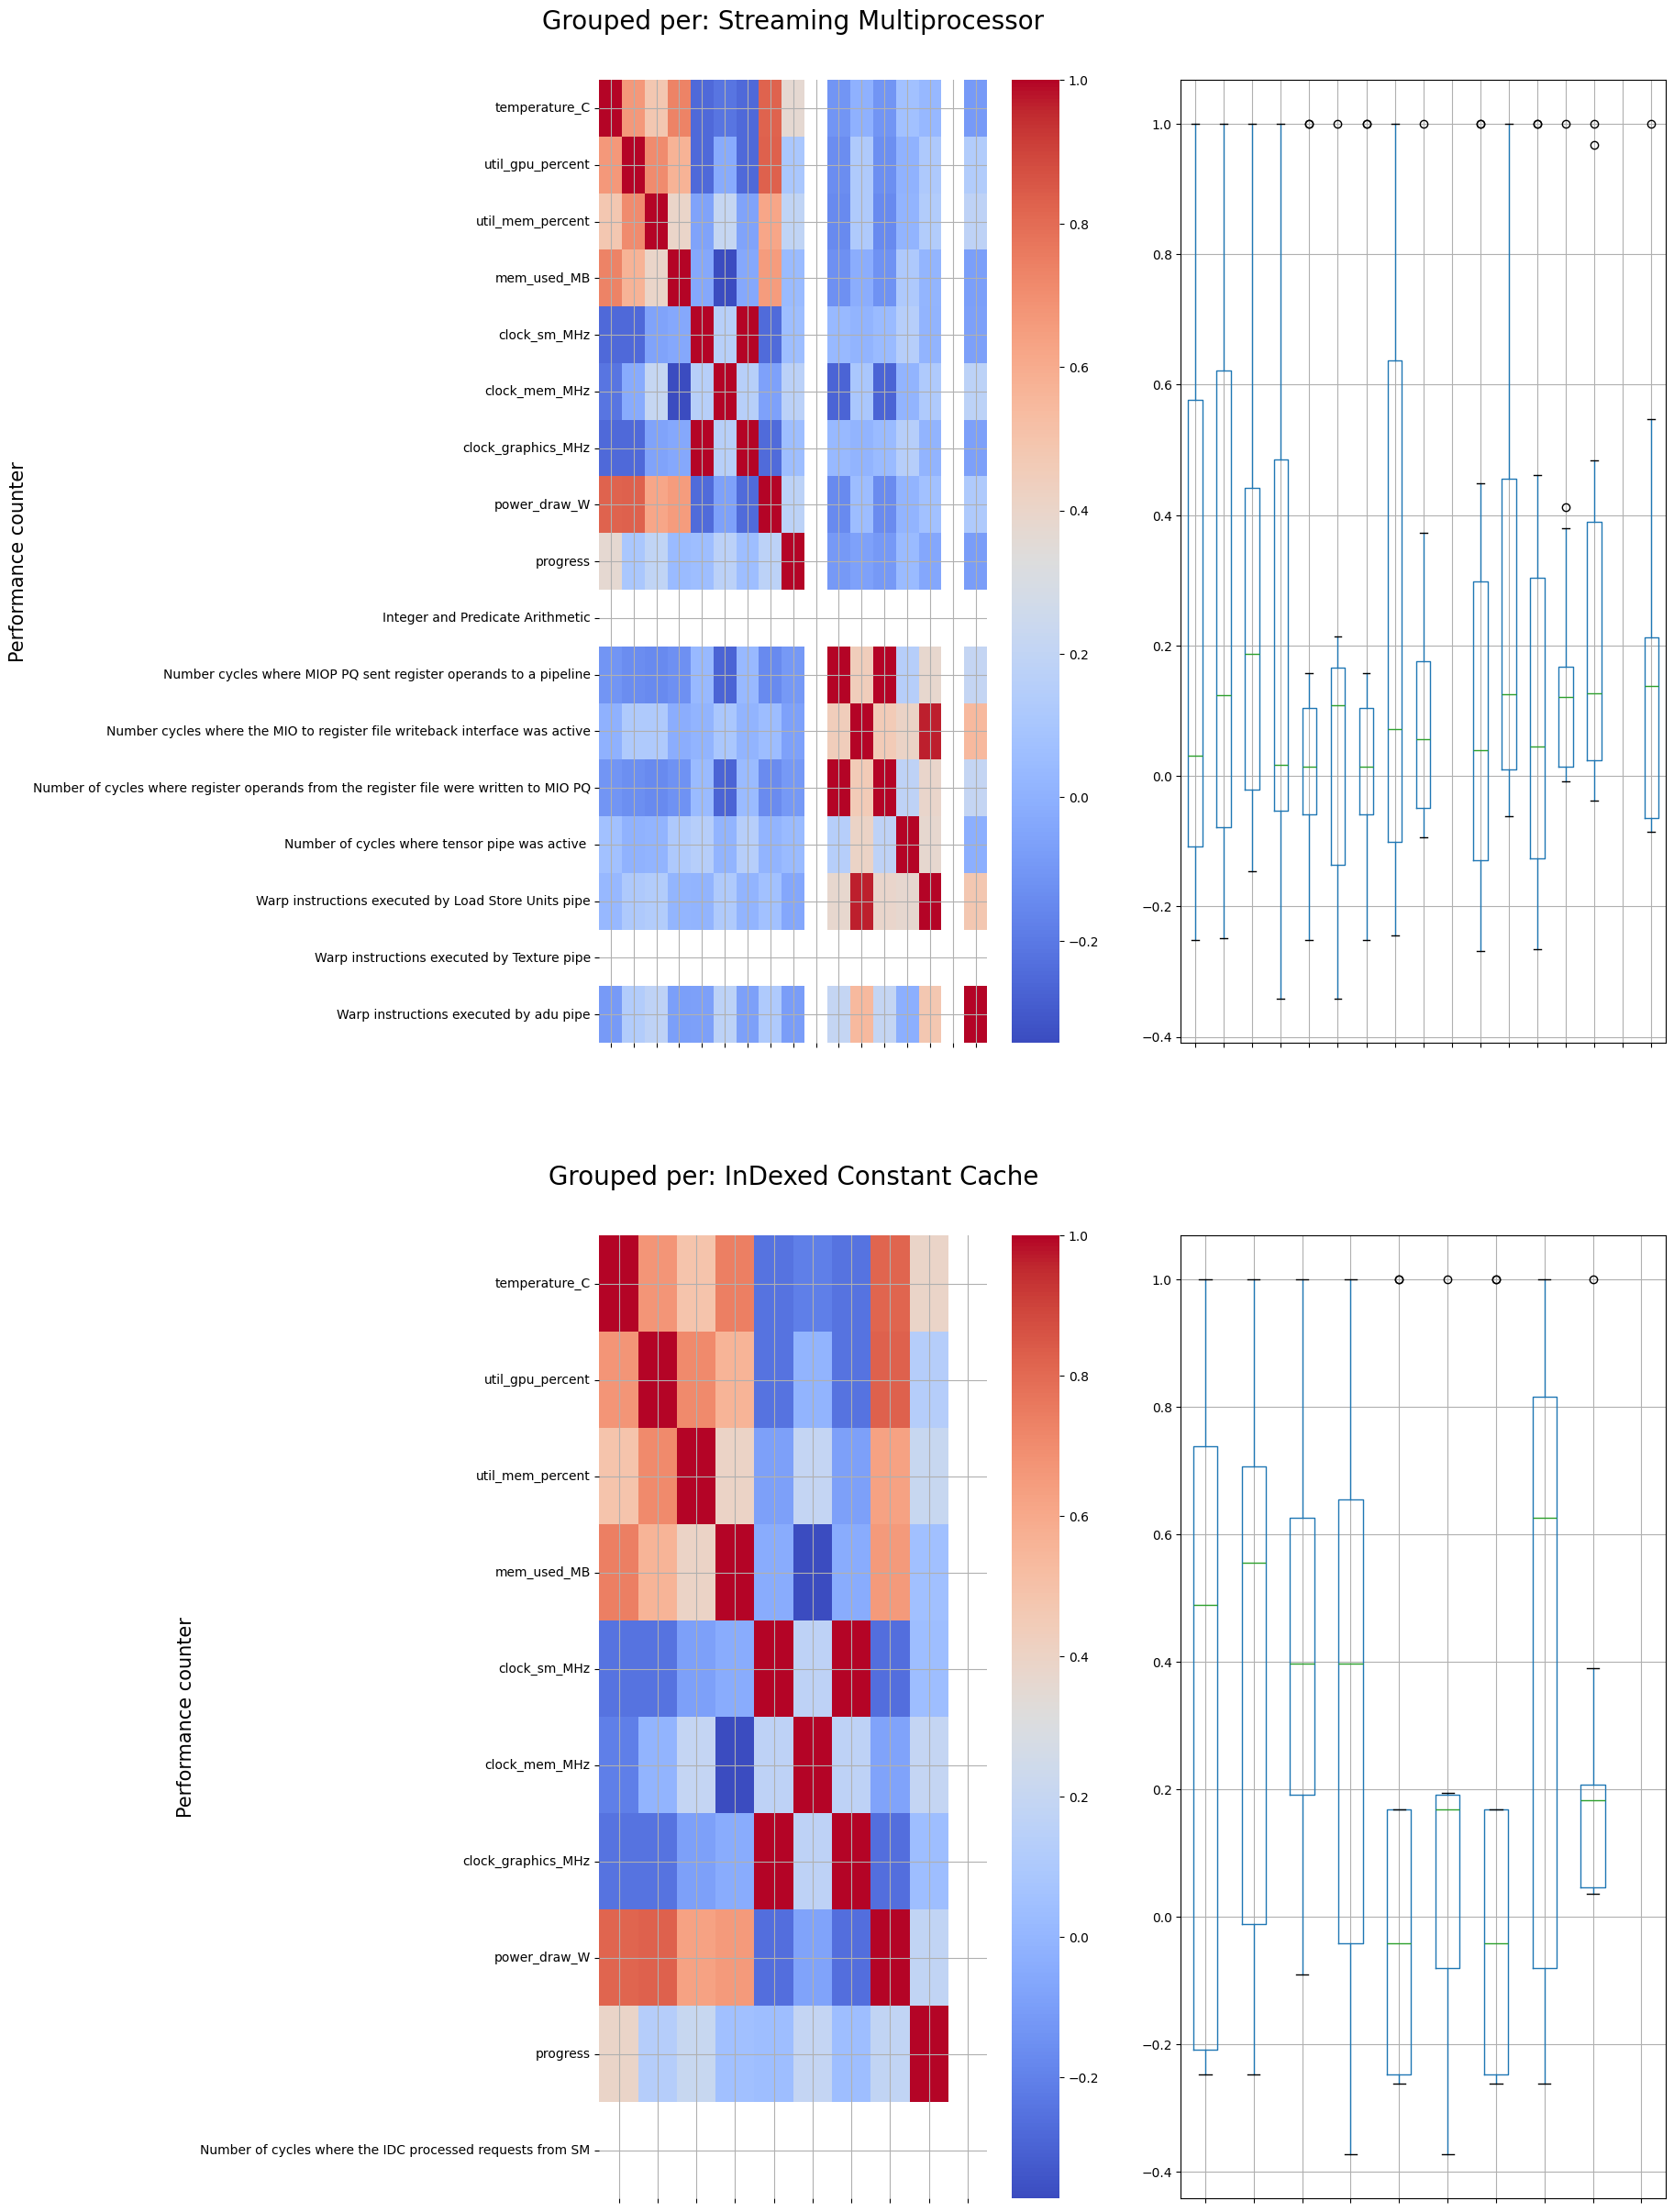

In [13]:
fig, ax = plt.subplots(2,2,figsize=(15,30))
group1 = ['temperature_C', 'util_gpu_percent', 'util_mem_percent', 'mem_used_MB',
       'clock_sm_MHz', 'clock_mem_MHz', 'clock_graphics_MHz', 'power_draw_W']
group2 = []
for pivot_df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[pivot_df_idx]
    print(HR_location)
    data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

In [16]:
for pivot_df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[pivot_df_idx]
    if HR_location == 'Streaming Multiprocessor':
        group2=['Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where alu pipe was active ',
       'Number of cycles where an SMSP issued an instruction',
       'Number of cycles where fp64 pipe was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of instructions issued from MIOC (Controller) to MIO',
       'Warp instructions executed',
       'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe',
       'Warp instructions executed by uniform pipe']
    else:
        group2 =['Number of cycles where the IDC processed requests from SM']
    data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    # print(data_to_corr[])
    corr_matrix = data_to_corr[group1].corrwith(data_to_corr[group2], axis=0)
    print(corr_matrix)
    break

KeyError: "['Number of cycles where alu pipe was active ', 'Number of cycles where an SMSP issued an instruction', 'Number of cycles where fp64 pipe was active', 'Number of instructions issued from MIOC (Controller) to MIO', 'Warp instructions executed', 'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on', 'Warp instructions executed by uniform pipe'] not in index"